In [8]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# Plot settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [4]:
category_sales_raw = pd.read_csv("data/raw/category_sales.csv")
sales_summary_raw = pd.read_csv("data/raw/salessummary2.csv")
detail_items = pd.read_csv("data/raw/detail_item_summary.csv")

In [7]:
# Helper function to clean currency strings
def clean_currency_column(series):
    return (
        series.replace(r'[\$,US]', '', regex=True)
              .replace(',', '', regex=True)
              .astype(float)
    )


# === Clean category_sales ===
category_sales = category_sales_raw.copy()
category_sales.columns = category_sales.columns.str.strip()
category_sales = category_sales.melt(id_vars="Category", var_name="Date Range", value_name="Revenue")
category_sales["Revenue"] = clean_currency_column(category_sales["Revenue"])

# === Clean sales_summary ===
sales_summary = sales_summary_raw.copy()
sales_summary.columns = sales_summary.columns.str.strip()
sales_summary = sales_summary.melt(id_vars="Sales", var_name="Date Range", value_name="Amount")
sales_summary["Amount"] = clean_currency_column(sales_summary["Amount"])

# === Clean detail_items ===
detail_items.columns = detail_items.columns.str.strip()
for col in ["Gross Sales", "Discounts", "Refunds"]:
    if col in detail_items.columns:
        detail_items[col] = clean_currency_column(detail_items[col])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1077 non-null   object 
 1   Time                   1077 non-null   object 
 2   Time Zone              1077 non-null   object 
 3   Category               1034 non-null   object 
 4   Item                   1077 non-null   object 
 5   Qty                    1077 non-null   float64
 6   Price Point Name       959 non-null    object 
 7   SKU                    0 non-null      float64
 8   Modifiers Applied      811 non-null    object 
 9   Gross Sales            1077 non-null   float64
 10  Discounts              1077 non-null   float64
 11  Net Sales              1077 non-null   object 
 12  Tax                    1077 non-null   object 
 13  Transaction ID         1077 non-null   object 
 14  Payment ID             1077 non-null   object 
 15  Devi

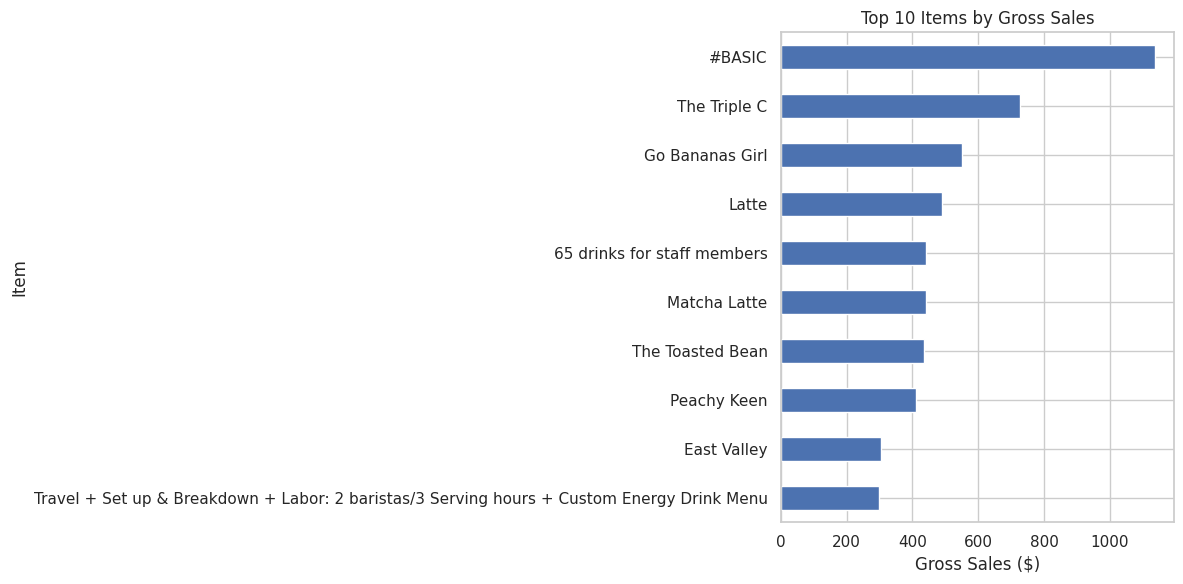

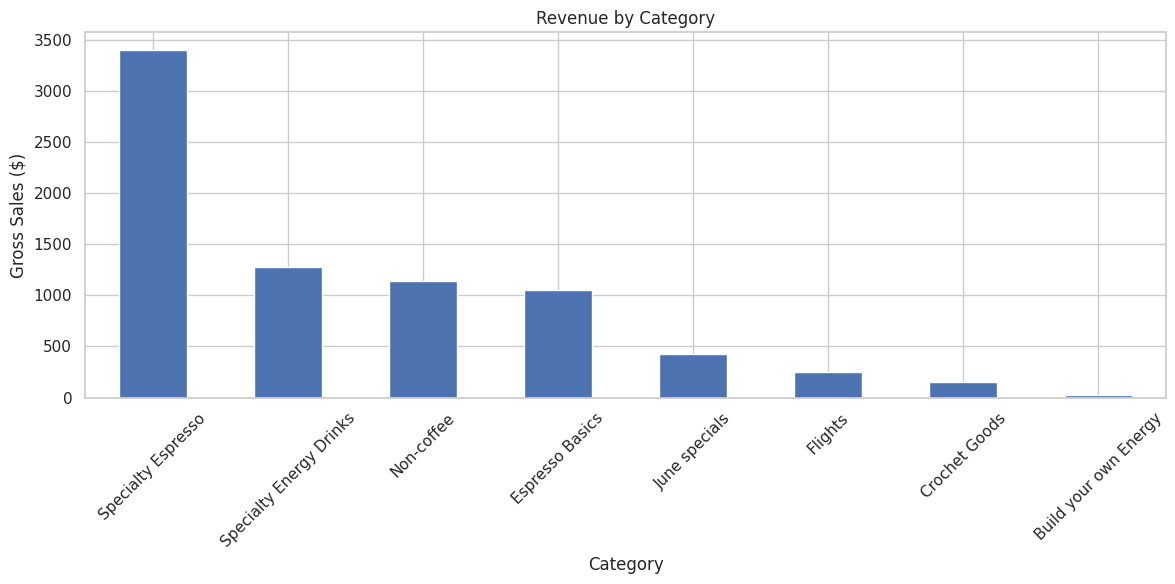

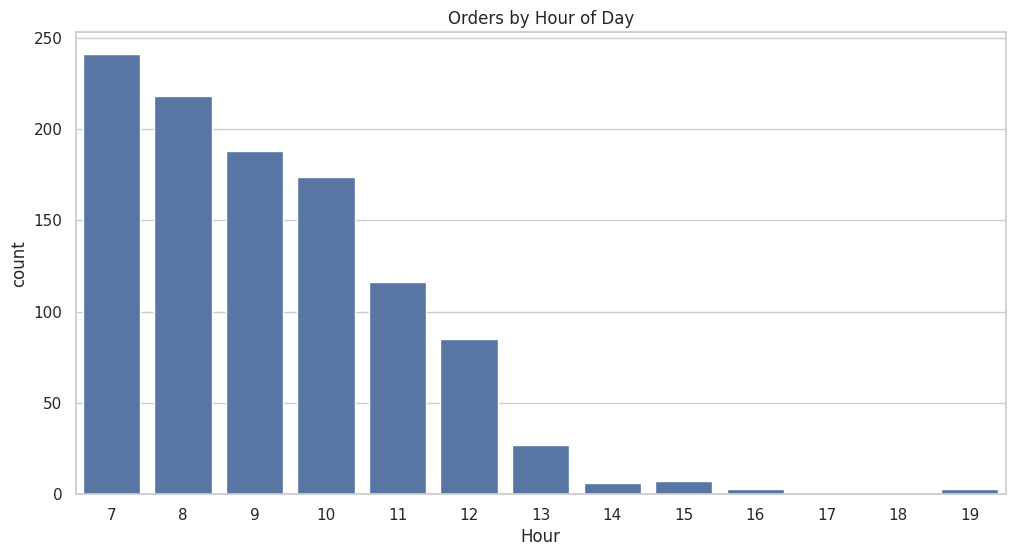

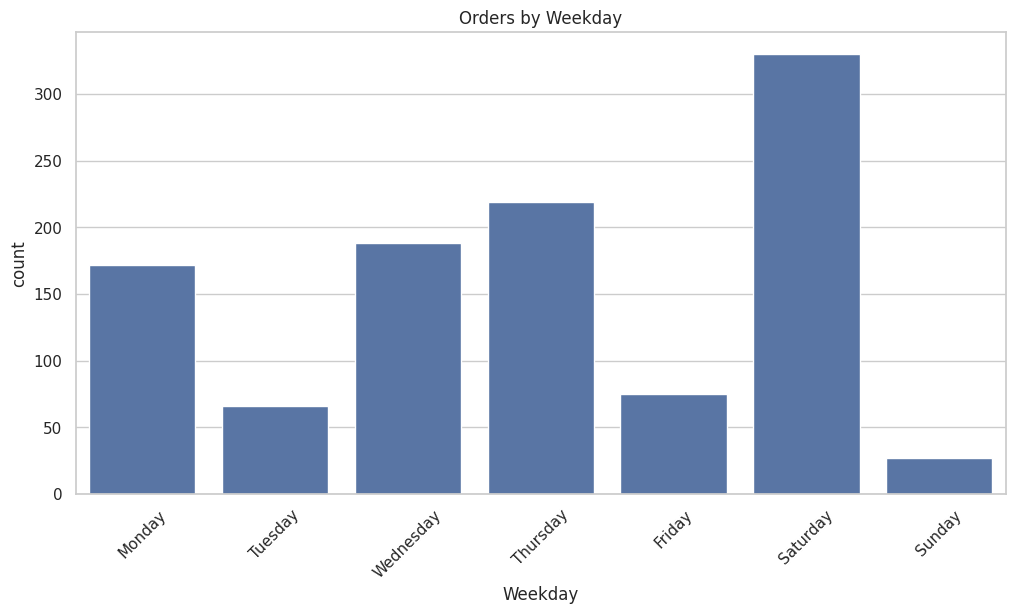

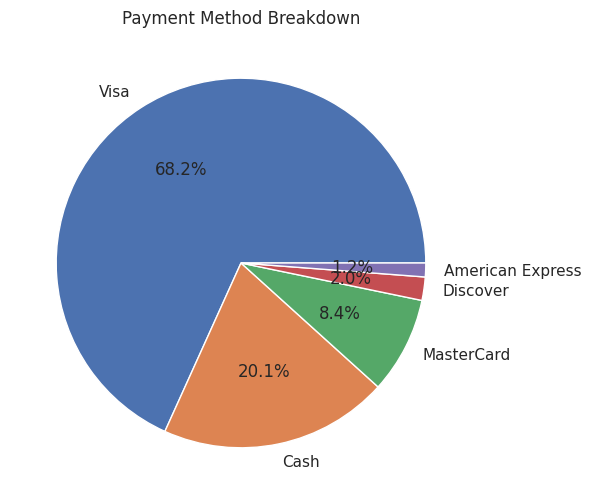

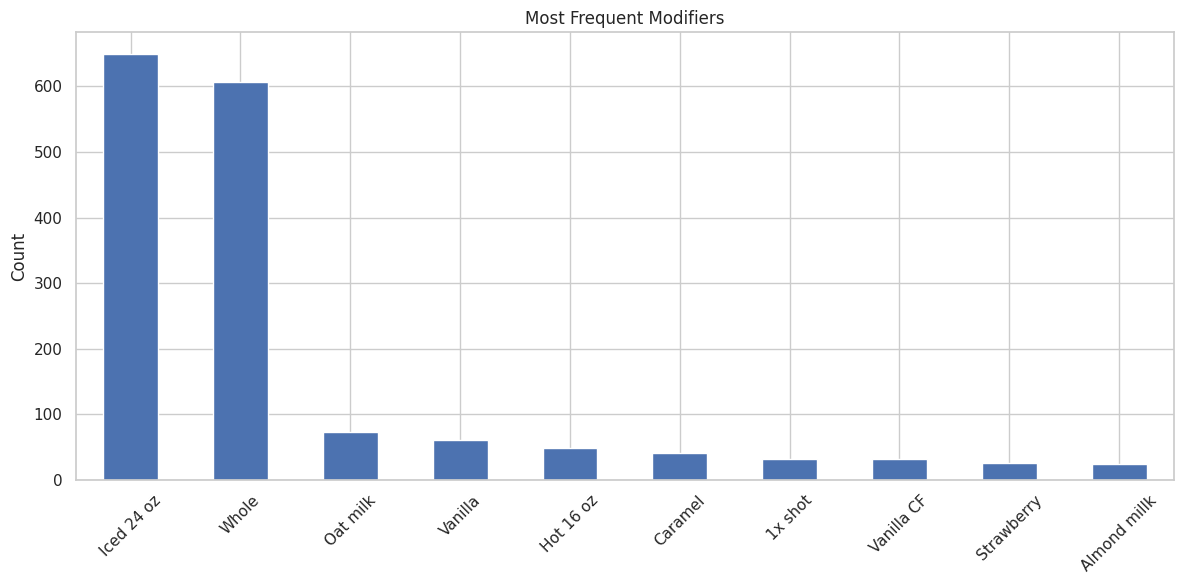

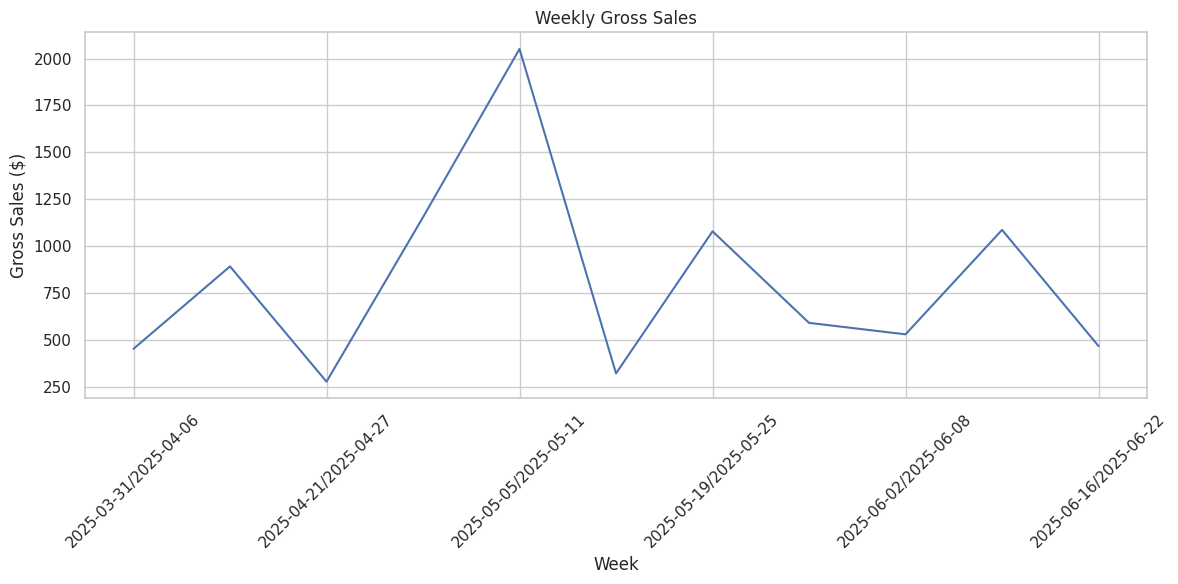

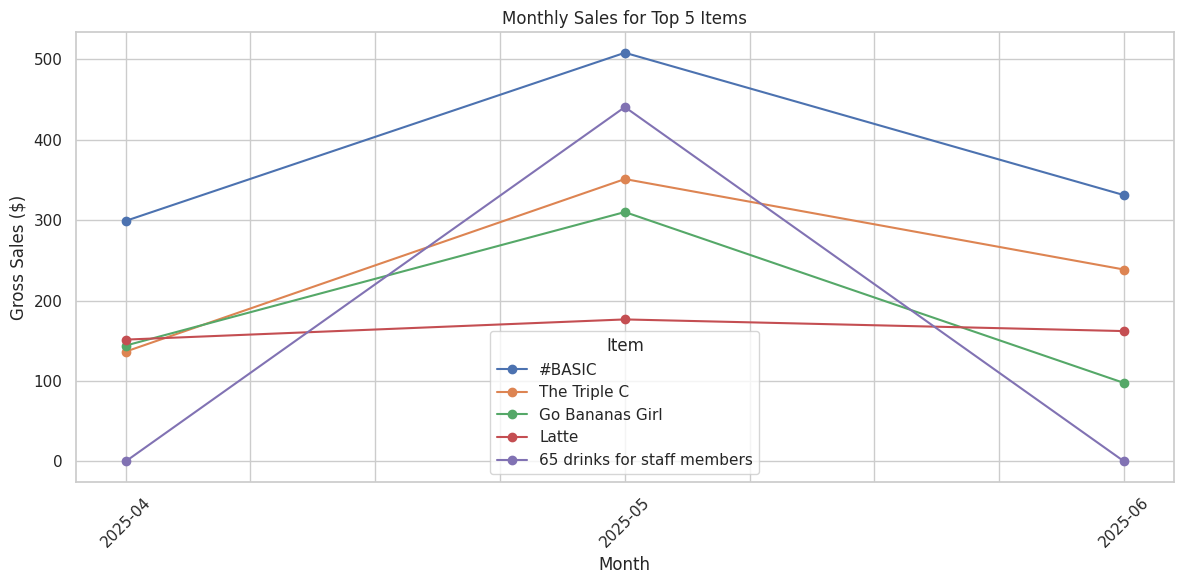

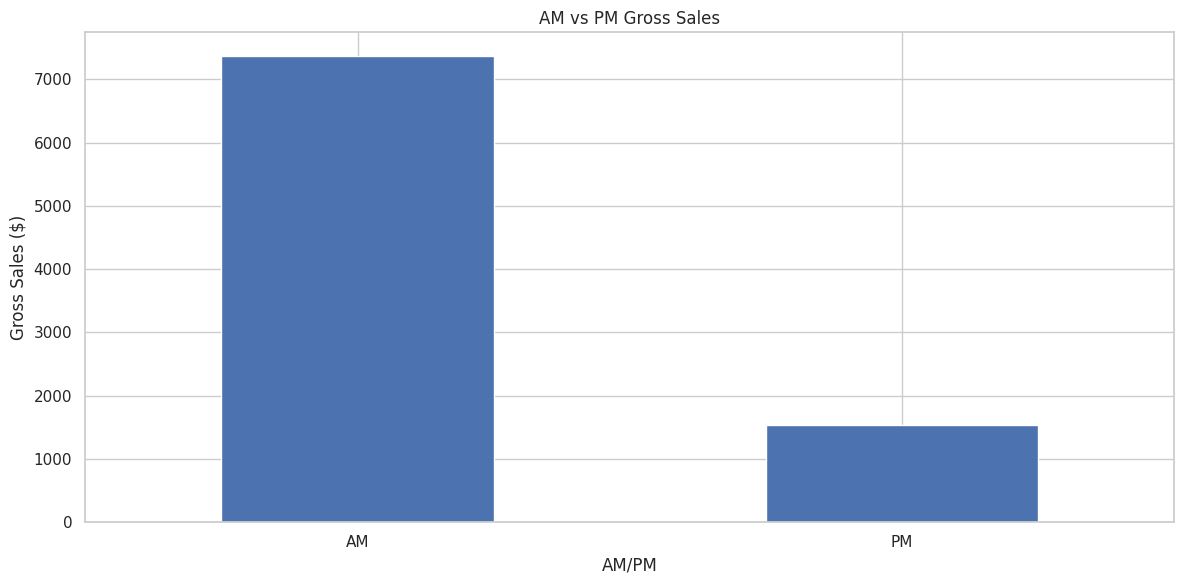

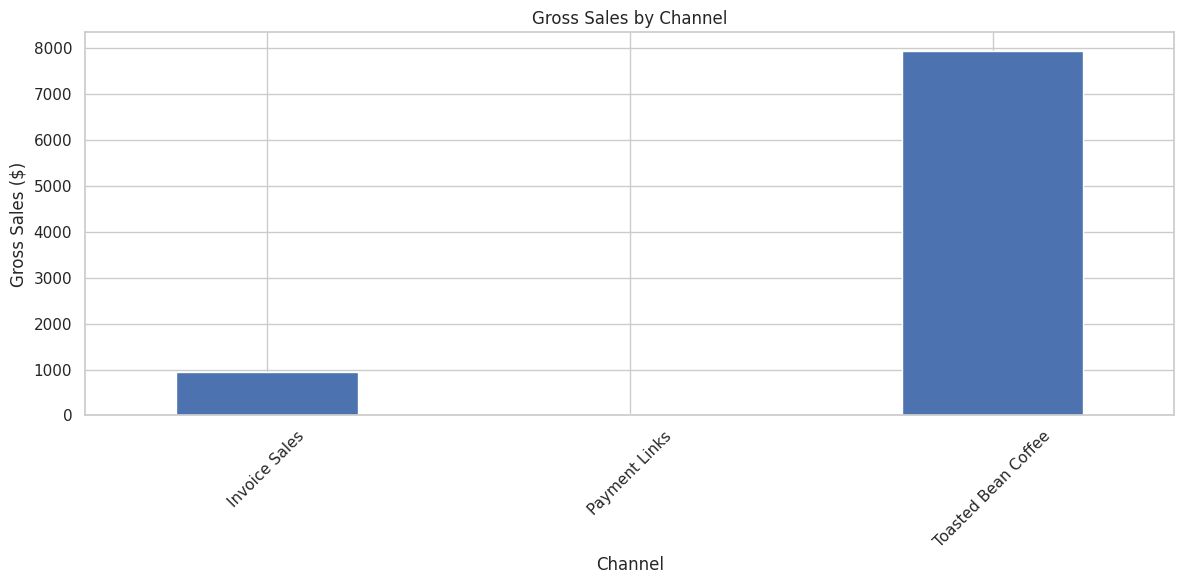

✅ Cleaned data exported.


In [14]:
# === 01_eda_cleaning.ipynb ===
# Initial Coffee Truck EDA Notebook

# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

# Plot settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Currency cleaner
def clean_currency_column(series):
    return (
        series.replace(r'[\$,US]', '', regex=True)
              .replace(',', '', regex=True)
              .astype(float)
    )

# --- 2. Load Cleaned Data ---
category_sales = pd.read_csv("data/raw/category_sales.csv")
sales_summary = pd.read_csv("data/raw/salessummary2.csv")
detail_items = pd.read_csv("data/raw/detail_item_summary.csv")

# Clean money columns in detail_items
for col in ["Gross Sales", "Discounts"]:
    if col in detail_items.columns:
        detail_items[col] = clean_currency_column(detail_items[col])

# --- 3. Quick Overview ---
print(detail_items.info())
print(detail_items.describe(include='all'))
print("Missing values:\n", detail_items.isnull().sum())

# --- 4. Sales KPIs ---
total_gross = detail_items['Gross Sales'].sum()
total_discounts = detail_items['Discounts'].sum() if 'Discounts' in detail_items.columns else 0.0
total_refunds = 0.0  # Refunds column not found
num_orders = detail_items.shape[0]

print(f"Total Gross Sales: ${total_gross:,.2f}")
print(f"Total Discounts Given: ${total_discounts:,.2f}")
print(f"Total Refunds: ${total_refunds:,.2f}")
print(f"Total Orders: {num_orders}")

# --- 5. Top Items and Categories ---
top_items = detail_items.groupby("Item")['Gross Sales'].sum().sort_values(ascending=False).head(10)
top_items.plot(kind='barh', title="Top 10 Items by Gross Sales")
plt.gca().invert_yaxis()
plt.xlabel("Gross Sales ($)")
plt.tight_layout()
plt.show()

category_totals = detail_items.groupby("Category")["Gross Sales"].sum().sort_values(ascending=False)
category_totals.plot(kind='bar', title="Revenue by Category")
plt.ylabel("Gross Sales ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 6. Time-Based Analysis ---
detail_items['Datetime'] = pd.to_datetime(detail_items['Date'] + ' ' + detail_items['Time'])
detail_items['Hour'] = detail_items['Datetime'].dt.hour
detail_items['Weekday'] = detail_items['Datetime'].dt.day_name()

sns.countplot(data=detail_items, x='Hour', order=range(7, 20))
plt.title("Orders by Hour of Day")
plt.show()

sns.countplot(data=detail_items, x='Weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Orders by Weekday")
plt.xticks(rotation=45)
plt.show()

# --- 7. Payment Methods ---
detail_items['Card Brand'] = detail_items['Card Brand'].fillna('Cash')
payment_counts = detail_items['Card Brand'].value_counts()
payment_counts.plot(kind='pie', autopct='%1.1f%%', title='Payment Method Breakdown')
plt.ylabel("")
plt.show()

# --- 8. Modifiers Overview ---
modifiers = detail_items['Modifiers Applied'].dropna()
mod_list = modifiers.str.split(', ').sum()
mod_freq = pd.Series(Counter(mod_list)).sort_values(ascending=False).head(10)
mod_freq.plot(kind='bar', title="Most Frequent Modifiers")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 9. Advanced Time Grouping ---
detail_items['Week'] = detail_items['Datetime'].dt.to_period('W').astype(str)
detail_items['Month'] = detail_items['Datetime'].dt.to_period('M').astype(str)

weekly_sales = detail_items.groupby('Week')['Gross Sales'].sum()
weekly_sales.plot(title="Weekly Gross Sales")
plt.ylabel("Gross Sales ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 10. Item Growth Over Time ---
item_monthly = detail_items.groupby(['Month', 'Item'])['Gross Sales'].sum().reset_index()
item_pivot = item_monthly.pivot(index='Month', columns='Item', values='Gross Sales').fillna(0)

item_pivot[top_items.index[:5]].plot(marker='o')
plt.title("Monthly Sales for Top 5 Items")
plt.ylabel("Gross Sales ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 11. Filtered Summaries ---
detail_items['AM/PM'] = detail_items['Hour'].apply(lambda h: 'AM' if h < 12 else 'PM')
am_pm_summary = detail_items.groupby('AM/PM')['Gross Sales'].sum()
channel_summary = detail_items.groupby('Channel')['Gross Sales'].sum()

am_pm_summary.plot(kind='bar', title="AM vs PM Gross Sales")
plt.ylabel("Gross Sales ($)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

channel_summary.plot(kind='bar', title="Gross Sales by Channel")
plt.ylabel("Gross Sales ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 12. Export Option ---
detail_items.to_csv("data/cleaned_detail_items.csv", index=False)
category_sales.to_csv("data/cleaned_category_sales.csv", index=False)
sales_summary.to_csv("data/cleaned_sales_summary.csv", index=False)
print("✅ Cleaned data exported.")


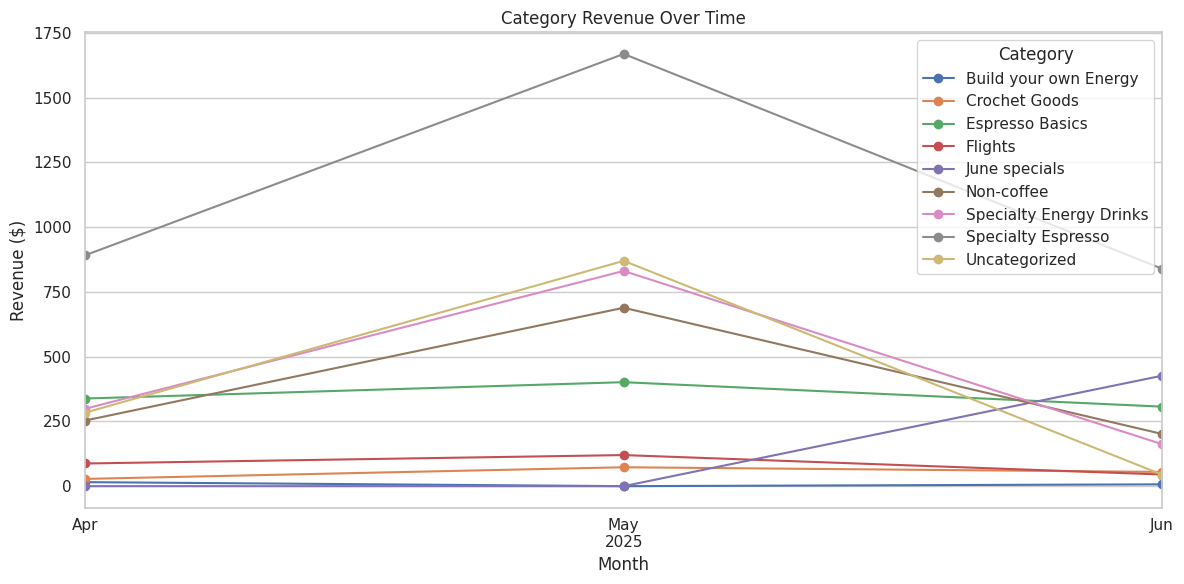

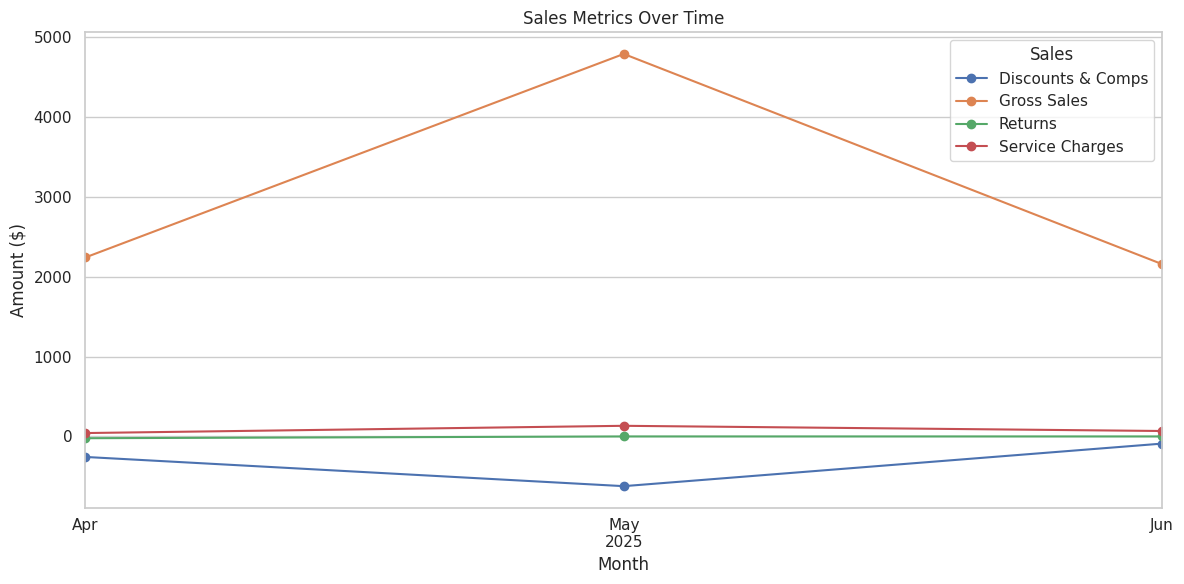


📈 Top 3 Revenue Categories (Total Period):
Category
Specialty Espresso         3400.2
Specialty Energy Drinks    1292.0
Uncategorized              1198.5
Name: Revenue, dtype: float64

📊 Month-over-Month Category Change:
Month                    2025-05-01 00:00:00  2025-06-01 00:00:00  Change (%)
Category                                                                     
Build your own Energy                   0.00                  7.0         inf
June specials                           0.00                426.5         inf
Espresso Basics                       401.50                307.0  -23.536737
Crochet Goods                          73.00                 55.0  -24.657534
Specialty Espresso                   1669.00                839.5  -49.700419
Flights                               120.00                 45.0  -62.500000
Non-coffee                            688.85                201.5  -70.748349
Specialty Energy Drinks               831.00                162.0  -80.50541

In [15]:
# === 01_eda_cleaning.ipynb ===
# Initial Coffee Truck EDA Notebook

# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

# Plot settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Currency cleaner
def clean_currency_column(series):
    return (
        series.replace(r'[\$,US]', '', regex=True)
              .replace(',', '', regex=True)
              .astype(float)
    )

# --- 2. Load Cleaned Data ---
category_sales = pd.read_csv("data/raw/cleaned_category_sales.csv")
sales_summary = pd.read_csv("data/cleaned/cleaned_sales_summary.csv")
detail_items = pd.read_csv("data/cleaned/cleaned_detail_items.csv")

# Clean monetary columns if needed
for df in [category_sales, sales_summary]:
    for col in df.columns[1:]:
        df[col] = clean_currency_column(df[col])

# Melt category_sales for long format
category_long = category_sales.melt(id_vars='Category', var_name='Month', value_name='Revenue')
category_long['Month'] = pd.to_datetime(category_long['Month'].str[:10])

# Melt sales_summary for long format
sales_summary_long = sales_summary.melt(id_vars='Sales', var_name='Month', value_name='Amount')
sales_summary_long['Month'] = pd.to_datetime(sales_summary_long['Month'].str[:10])

# --- 13. Category Revenue Trends ---
cat_pivot = category_long.pivot(index='Month', columns='Category', values='Revenue')
cat_pivot.plot(marker='o')
plt.title("Category Revenue Over Time")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 14. Sales Summary Trends ---
summary_focus = ['Gross Sales', 'Discounts & Comps', 'Returns', 'Service Charges']
sales_filtered = sales_summary_long[sales_summary_long['Sales'].isin(summary_focus)]
sales_pivot = sales_filtered.pivot(index='Month', columns='Sales', values='Amount')
sales_pivot.plot(marker='o')
plt.title("Sales Metrics Over Time")
plt.ylabel("Amount ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 15. High-Level Takeaways ---
top_growth = category_long.groupby('Category')['Revenue'].sum().sort_values(ascending=False).head(3)
print("\n📈 Top 3 Revenue Categories (Total Period):")
print(top_growth)

latest_month = category_long['Month'].max()
prev_month = latest_month - pd.DateOffset(months=1)

month_comp = category_long[category_long['Month'].isin([prev_month, latest_month])]
category_change = month_comp.pivot(index='Category', columns='Month', values='Revenue').dropna()
category_change['Change (%)'] = ((category_change.iloc[:,1] - category_change.iloc[:,0]) / category_change.iloc[:,0]) * 100
print("\n📊 Month-over-Month Category Change:")
print(category_change.sort_values(by='Change (%)', ascending=False))

print("\n✅ Summary charts and business takeaways updated.")
